In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV


### Load Training Data

In [15]:
df = pd.read_csv('Data/train.csv')
df = df.sample(6000)  #60000
X_train = df.drop('labels', axis='columns')
y_train = df['labels'].values.ravel()

In [16]:
print(X_train.shape,y_train.shape)
print(pd.Series(y_train).value_counts(normalize=True))

(6000, 108) (6000,)
1    0.799167
0    0.200833
dtype: float64


### Load Testing Data

In [17]:
df = pd.read_csv('Data/test.csv')
df = df.sample(1000)  #10000
X_test = df.drop('labels', axis='columns')
y_test = df['labels'].values.ravel()

In [18]:
print(X_test.shape,y_test.shape)
print(pd.Series(y_test).value_counts(normalize=True))

(1000, 108) (1000,)
1    0.806
0    0.194
dtype: float64


### Fit the models

In [19]:
classifiers = [GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, 
                                          max_features=50, max_depth=15, random_state=89),
               
              LogisticRegression(random_state=42, solver='sag', max_iter=10000, C=5,
                                 class_weight={1:0.3,0:0.7}),
              
              GaussianNB()]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc',
                                    'precision','recall',
                                    'precision score'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    precision, recall, _ = precision_recall_curve(y_test,yproba)
    average_precision = average_precision_score(y_test,yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'precision':precision,
                                        'recall':recall,
                                        'precision score':average_precision}, 
                                       ignore_index=True)
    
    print('{} - DONE'.format(cls))

result_table.set_index('classifiers', inplace=True)

GradientBoostingClassifier(max_depth=15, max_features=50, n_estimators=1000,
                           random_state=89) - DONE
LogisticRegression(C=5, class_weight={0: 0.7, 1: 0.3}, max_iter=10000,
                   random_state=42, solver='sag') - DONE
GaussianNB() - DONE


In [20]:
result_table

,fpr,tpr,auc,precision,recall,precision score
classifiers,,,,,,
GradientBoostingClassifier,"[0.0, 0.0, 0.005154639175257732, 0.01030927835...","[0.0, 0.019851116625310174, 0.0359801488833746...",0.746080,"[0.8258196721311475, 0.8256410256410256, 0.826...","[1.0, 0.9987593052109182, 0.9987593052109182, ...",0.910745
LogisticRegression,"[0.0, 0.0, 0.0, 0.005154639175257732, 0.005154...","[0.0, 0.0012406947890818859, 0.055831265508684...",0.777142,"[0.8343685300207039, 0.8341968911917098, 0.835...","[1.0, 0.9987593052109182, 0.9987593052109182, ...",0.928877
GaussianNB,"[0.0, 0.11855670103092783, 0.11855670103092783...","[0.0, 0.4044665012406948, 0.40694789081885857,...",0.749313,"[0.828365878725591, 0.8281893004115226, 0.8280...","[1.0, 0.9987593052109182, 0.9975186104218362, ...",0.909253


All three models have high precision scores. The AUC for the three classifiers are in acceptable range. The Logistic Regression scores the best at 0.714913.

### Recall vs. Precision Curve

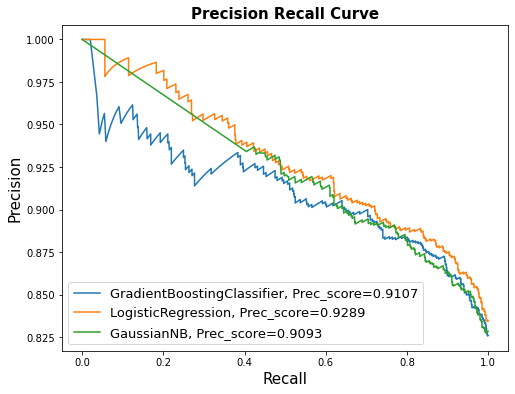

In [28]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['precision'],
            label="{}, Prec_score={:.4f}".format(i, result_table.loc[i]['precision score']))
    
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)

plt.title('Precision Recall Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')
#plt.savefig('images/recall_precision.png')
plt.show()


All three models have a high area under the precision-recall curve representing both high recall and high precision (where high precision relates to a low false positive rate, and high recall relates to a low false negative rate).

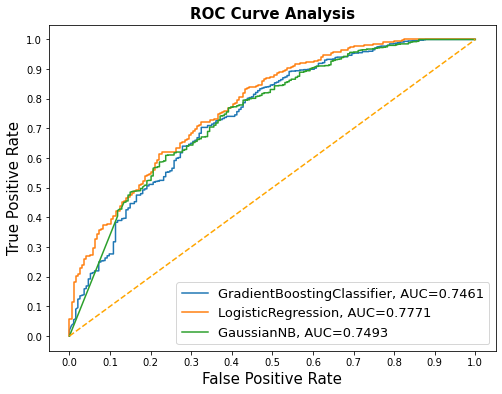

In [22]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.4f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
#plt.savefig('images/ROC.png')
plt.show()

ROC curve represents a relation between sensitivity (RECALL) and specificity(NOT PRECISION) and is commonly used to measure the performance of binary classifiers. All three of these models fall within an acceptable range.

In [23]:
for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    prediction = algo.predict(X_test)
    print(classification_report(y_test, prediction))

############## GradientBoostingClassifier ##############
              precision    recall  f1-score   support

           0       0.68      0.25      0.36       194
           1       0.84      0.97      0.90       806

    accuracy                           0.83      1000
   macro avg       0.76      0.61      0.63      1000
weighted avg       0.81      0.83      0.80      1000

############## LogisticRegression ##############
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       194
           1       0.88      0.88      0.88       806

    accuracy                           0.80      1000
   macro avg       0.69      0.68      0.69      1000
weighted avg       0.80      0.80      0.80      1000

############## GaussianNB ##############
              precision    recall  f1-score   support

           0       0.74      0.19      0.30       194
           1       0.83      0.98      0.90       806

    accuracy                       

In [24]:
threshold = 0.9

for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    predict_proba = algo.predict_proba(X_test)[:,1] >= threshold
    print(classification_report(y_test, predict_proba))

############## GradientBoostingClassifier ##############
              precision    recall  f1-score   support

           0       0.60      0.29      0.39       194
           1       0.85      0.95      0.90       806

    accuracy                           0.82      1000
   macro avg       0.73      0.62      0.64      1000
weighted avg       0.80      0.82      0.80      1000

############## LogisticRegression ##############
              precision    recall  f1-score   support

           0       0.22      0.99      0.36       194
           1       0.99      0.16      0.28       806

    accuracy                           0.32      1000
   macro avg       0.60      0.58      0.32      1000
weighted avg       0.84      0.32      0.30      1000

############## GaussianNB ##############
              precision    recall  f1-score   support

           0       0.73      0.20      0.31       194
           1       0.84      0.98      0.90       806

    accuracy                       

The f1 score is a measure of a test's accuracy - a weighted average of the precision and recall. For each of these models, we see a high f1. However, when the threshold is set to 0.9, the f1-score of the Logisti Regression model drops significantly from 0.75 to 0.29. 

In [25]:
logreg = LogisticRegression(solver='sag', max_iter=10000)
param = {'C':[10,15,25,20]}
clf = GridSearchCV(logreg,param,scoring='precision',refit=True,cv=10)
clf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with hyperparameter: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8301, with hyperparameter: {'C': 25}


In [27]:
filename = 'Models/logreg_model.sav'
#the object you want to pickle and the file to which the object has to be saved - filename, write binary. 
outfile = open(filename,'wb')
pickle.dump(logreg, outfile)
outfile.close()

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))